In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import turtle
import requests # For reading image from URL
from google.colab.patches import cv2_imshow # For displaying image in Google Colab
from PIL import Image
import os

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<hr>
<font face="B Mitra" size=5>
<div dir=rtl>

<font size=6>
<b>تمرین اول</b>
</font>

<br>
<p align="justify">
<font size=4>
<p>  در این تمرین قصد داریم عملیات بخش بندی تصویر را با استفاده از region growing (که پیش‌تر توضیح داده شد) پیاده سازی کنیم. بدین منظور قصد داریم ماده سفید مغز و ماده خاکستری مغز را از پس زمینه جدا کنیم        </p>

</p>

<p>
<font size=4>

</font>
</p>

</div>
</font>

In [5]:
def download_image_from_url(url):
    filename, ext = url.split("/")[-1].split(".")
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    # Check if the request was successful (status code 200 indicates success)
    if response.status_code == 200:
        # Get the content of the response (the image data)
        image_data = response.content
        # Specify the path where you want to save the image
        save_path = f"{filename}.{ext}"  # Replace with the desired file name and location
        # Open a binary file in write mode and write the image data to it
        with open(save_path, "wb") as file:
            file.write(image_data)
        print(f"Image downloaded and saved as {save_path}")
        return cv2.imread(save_path)
    else:
        print(f"Failed to download the image. Status code: {response.status_code}")


Image downloaded and saved as Color-MRI.png


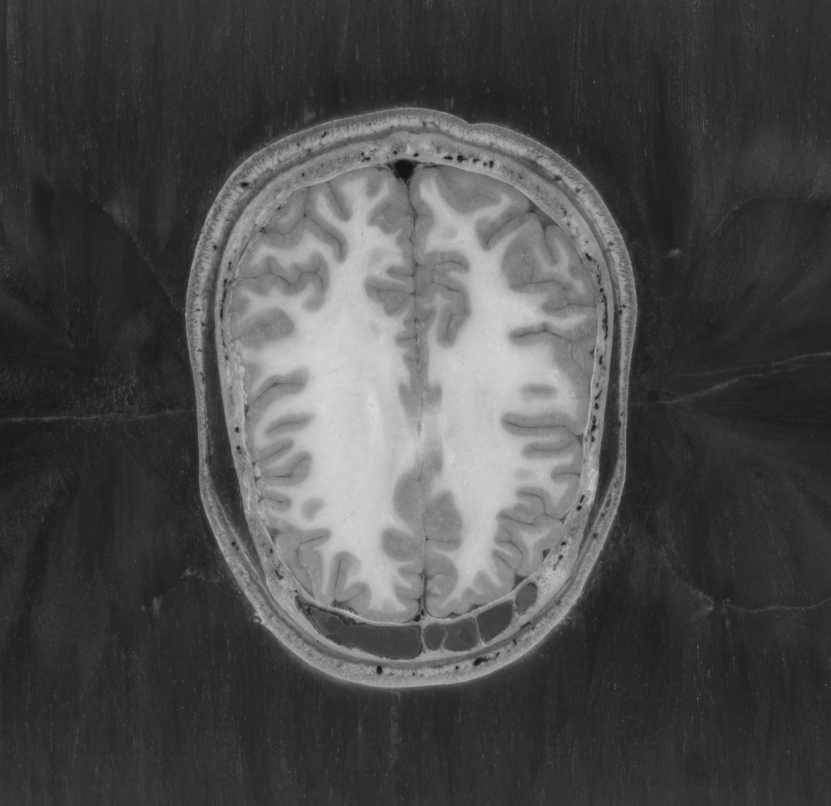

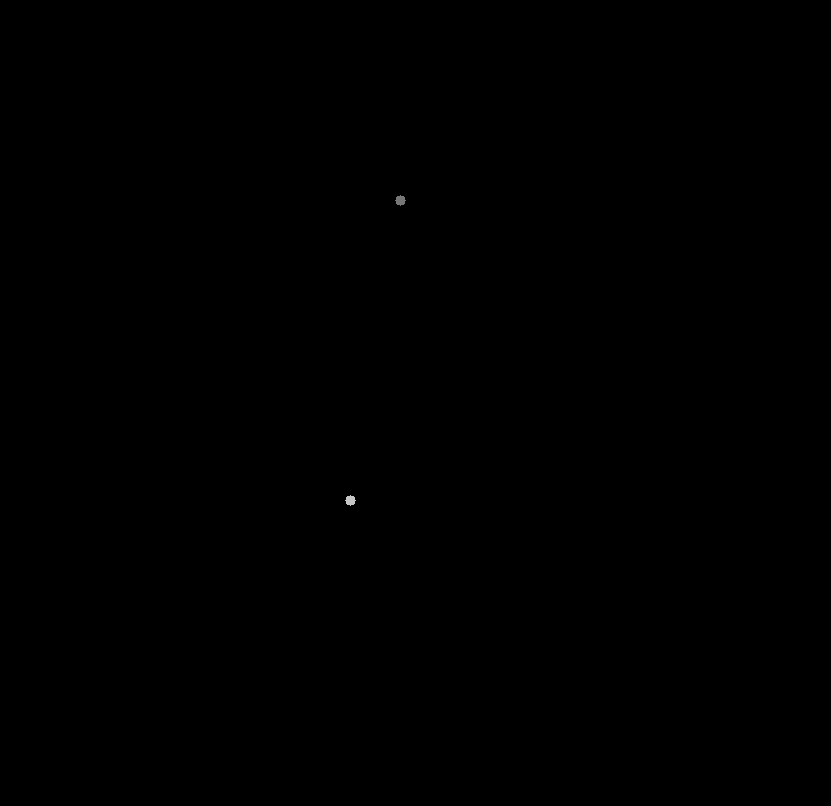

Selected seed points:
(350, 500)
(400, 200)


In [49]:
# Load the input image
img = download_image_from_url('https://i.ibb.co/yNvtxxw/Color-MRI.png')

# Display the original PNG image
# cv2_imshow(img)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

# Set two points manually
white_matter_seed = (350, 500)
gray_matter_seed = (400, 200)

# Get the intensity value at the selected seed points
white_matter_intensity = gray_img[white_matter_seed[1], white_matter_seed[0]]
gray_matter_intensity = gray_img[gray_matter_seed[1], gray_matter_seed[0]]

# Create an empty image to display grain points
empty_image = np.zeros_like(gray_img)

# Draw circles around the selected seed points on the empty image
cv2.circle(empty_image, white_matter_seed, 5, (int(white_matter_intensity),), -1)
cv2.circle(empty_image, gray_matter_seed, 5, (int(gray_matter_intensity),), -1)

# Display original image and blank image with grain points
cv2_imshow(empty_image)

# List to store seed points
seeds = [white_matter_seed, gray_matter_seed]
# Display seed points
print("Selected seed points:")
for seed in seeds:
    print(f"({seed[0]}, {seed[1]})")

white_seeds = [white_matter_seed]
gray_seeds = [gray_matter_seed]

In [7]:
def region_growing(img, seeds, thresh, diffType,label):
    height, weight = img.shape
    seedMark = np.zeros(img.shape)
    seedList = []
    steps = 1
    seeds_grayscale = []
    main_grayscale=seeds_grayscale
    seeds_avg_grayscale = 0

    for seed in seeds:
        seedList.append(seed)
        seeds_grayscale.append(img[seed[0], seed[1]])

    seeds_avg_grayscale = np.average(seeds_grayscale)

    connects = [ (0, -1), (1, 0),(0, 1), (-1, 0)]
    while(len(seedList)>0):
        currentPoint = seedList.pop(0)

        if (diffType == "average"):
            seeds_grayscale.append(img[currentPoint[0], currentPoint[1]])
            seeds_avg_grayscale = np.average(seeds_grayscale)
            seedMark[currentPoint[0], currentPoint[1]] = label

        if(diffType == "constant"):
            seeds_avg_grayscale = np.average(main_grayscale)
            seedMark[currentPoint[0], currentPoint[1]] = label

        for i in range(4):
            tmpX = currentPoint[0] + connects[i][0]
            tmpY = currentPoint[1] + connects[i][1]
            if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight:
                continue

            grayDiff = abs (img[tmpX, tmpY] - seeds_avg_grayscale)

            if grayDiff < thresh and seedMark[tmpX,tmpY] == 0:
                seedMark[tmpX,tmpY] = label
                seedList.append((tmpX,tmpY))
        steps +=1

    return steps, seedMark

<hr>
<font face="B Mitra" size=5>
<div dir=rtl>

<font size=6>
</font>

<br>
<p align="justify">
<font size=4>
<p>  آستانه هایی که تعریف شده بر اساس آزمون و خطا بدست آمده اند و حداکثر تفاوت شدت پیکسل ها را برای این که دو پیکسل در یک ناحیه باشند را نشان میدهد.  </p>

</p>

<p>
<font size=4>

</font>
</p>

</div>
</font>

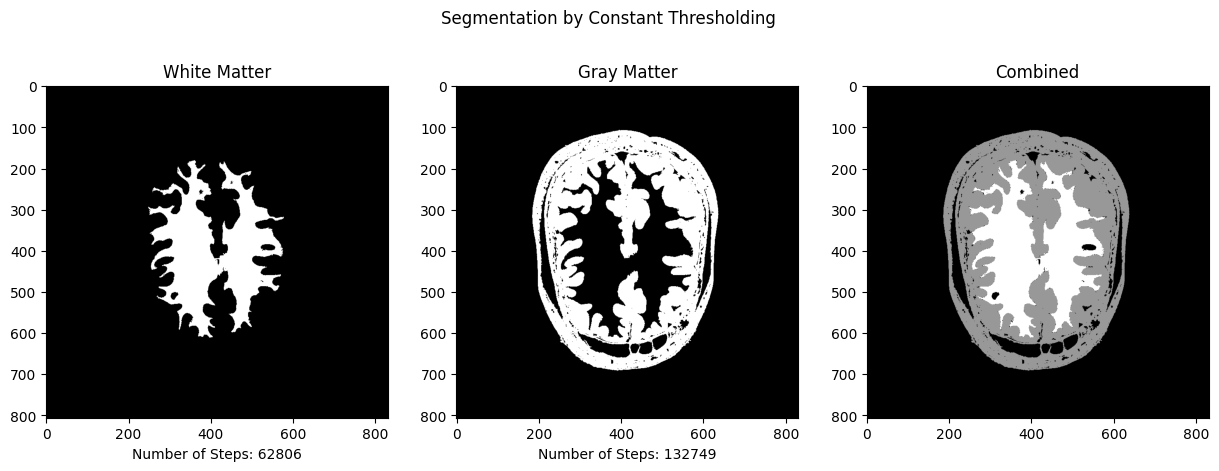

In [8]:
# Apply constant region growing for white matter
threshold_value_white = 40
steps_white, region_growing_result_white = region_growing(gray_img, white_seeds, threshold_value_white, "constant", white_matter_intensity)

# Apply constant region growing for gray matter
threshold_value_gray = 40
steps_gray, region_growing_result_gray = region_growing(gray_img, gray_seeds, threshold_value_gray, "constant", gray_matter_intensity)

# Create subplots
plt.figure(figsize=(15, 5))

# Plot white matter on the left
plt.subplot(1, 3, 1)
plt.imshow(region_growing_result_white, cmap='gray')
plt.title('White Matter')
plt.xlabel(f'Number of Steps: {steps_white}')

# Plot gray matter in the middle
plt.subplot(1, 3, 2)
plt.imshow(region_growing_result_gray, cmap='gray')
plt.title('Gray Matter')
plt.xlabel(f'Number of Steps: {steps_gray}')

# Plot the combination on the right
combined_result = region_growing_result_white + region_growing_result_gray
plt.subplot(1, 3, 3)
plt.imshow(combined_result, cmap='gray')
plt.title('Combined')

# Add a common title above the subplots
plt.suptitle('Segmentation by Constant Thresholding')

# Show the plots
plt.show()

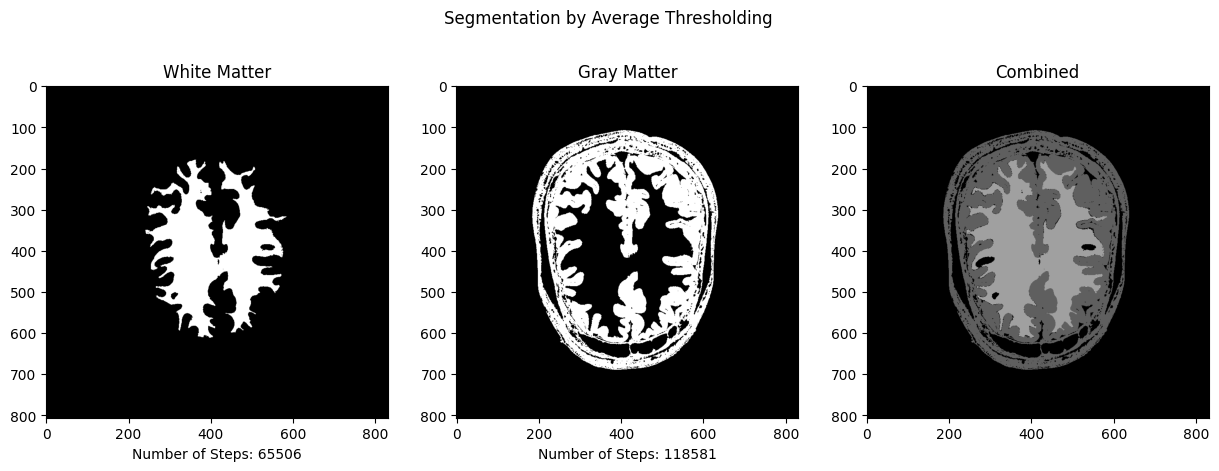

In [55]:
# Apply average region growing for white matter
threshold_value_white = 30
steps_white, region_growing_result_white = region_growing(gray_img, white_seeds, threshold_value_white, "average", white_matter_intensity)

# Apply average region growing for gray matter
threshold_value_gray = 30
steps_gray, region_growing_result_gray = region_growing(gray_img, gray_seeds, threshold_value_gray, "average", gray_matter_intensity)

# Create subplots
plt.figure(figsize=(15, 5))

# Plot white matter on the left
plt.subplot(1, 3, 1)
plt.imshow(region_growing_result_white, cmap='gray')
plt.title('White Matter')
plt.xlabel(f'Number of Steps: {steps_white}')

# Plot gray matter in the middle
plt.subplot(1, 3, 2)
plt.imshow(region_growing_result_gray, cmap='gray')
plt.title('Gray Matter')
plt.xlabel(f'Number of Steps: {steps_gray}')

# Plot the combination on the right
combined_result = region_growing_result_white + region_growing_result_gray
plt.subplot(1, 3, 3)
plt.imshow(combined_result, cmap='gray')
plt.title('Combined')

# Add a common title above the subplots
plt.suptitle('Segmentation by Average Thresholding')

# Show the plots
plt.show()

سمت چپ تصویر اصلی در مقیاس خاکستری مغز را نشان می دهد.
سمت راست نتیجه تقسیم بندی رو به رشد منطقه را نشان می دهد.
شما می توانید مشاهده کنید که الگوریتم رشد منطقه چقدر مناطق مختلف مغز را بر اساس نقاط بذر انتخابی و مقادیر آستانه جدا کرده است. تنظیم آستانه و نقاط بذر ممکن است بر نتایج تقسیم بندی تأثیر بگذارد.

<hr>
<font face="B Mitra" size=5>
<div dir=rtl>

<font size=6>
<b>تمرین دوم </b>
</font>

<br>
<p align="justify">
<font size=4>
<p>  در این تمرین قصد داریم سه روش مختلف interpolation یعنی nearest neighborhood , bilinear, bicubic را باهمدیگر مقایسه کنیم.
</p>

<p>
<font size=4>

</font>
</p>

</div>
</font>

In [10]:
!pip install pydicom
import pydicom

In [17]:
img_path = '/content/drive/MyDrive/file1.dcm'
dcm_img = pydicom.dcmread(img_path, force=True)

dcm_img

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.184912220734460823585918206046
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 422
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.1849

Number of allocated bits (for each pixel): 16
Number of stored bits (for each pixel): 12
Imaging method category: CT
Imaged body part: CHEST


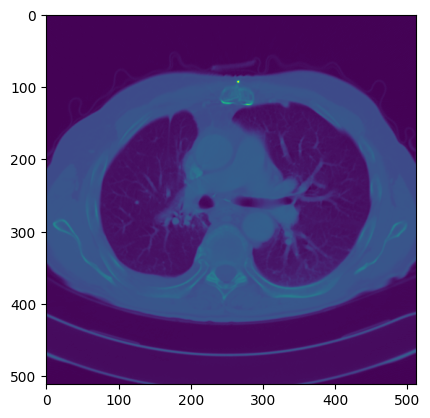

In [20]:
# Extract information
allocated_bits = dcm_img.BitsAllocated
stored_bits = dcm_img.BitsStored
imaging_method = dcm_img.Modality
imaged_body_part = dcm_img.BodyPartExamined

# Print the extracted information
print(f"Number of allocated bits (for each pixel): {allocated_bits}")
print(f"Number of stored bits (for each pixel): {stored_bits}")
print(f"Imaging method category: {imaging_method}")
print(f"Imaged body part: {imaged_body_part}")

img_array = dcm_img.pixel_array

plt.imshow(img_array)

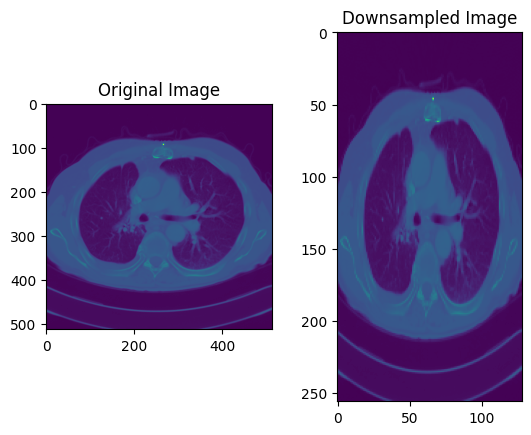

In [53]:
# Set the scale factor for downsampling
h_factor = 2
w_factor = 4

# Perform downsampling
# downsampled_image = downsample_nearest_neighbor(img_array, h_factor, w_factor)

# Reduce the number of pixels using cv2.resize
downsampled_image = cv2.resize(img_array, (img_array.shape[1] // 4, img_array.shape[0] // 2))

# Display the original and downsampled images
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(downsampled_image)
plt.title('Downsampled Image')

plt.show()

PSNR (Nearest-Neighbor): 13.8899 dB
PSNR (Bilinear): 16.7521 dB
PSNR (Bicubic): 18.7520 dB


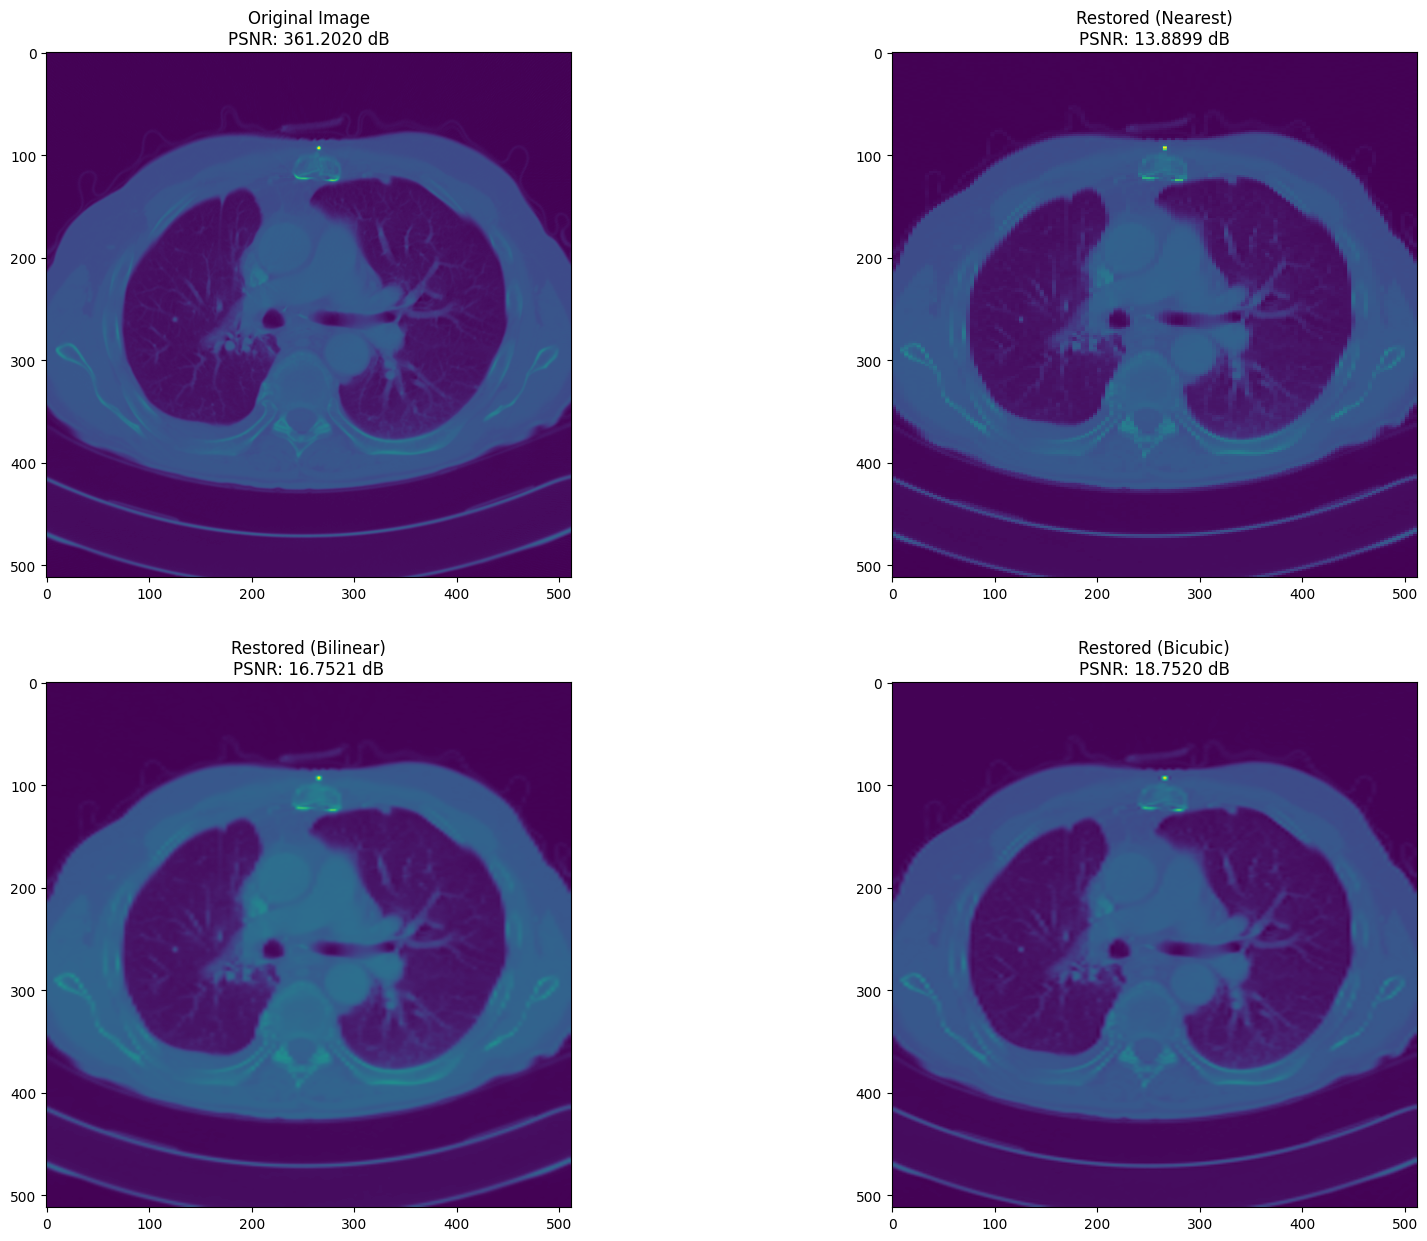

In [54]:
# Restore using nearest-neighbor interpolation
restored_nearest = cv2.resize(downsampled_image, (img_array.shape[1], img_array.shape[0]), interpolation=cv2.INTER_NEAREST)

# Restore using bilinear interpolation
restored_bilinear = cv2.resize(downsampled_image, (img_array.shape[1], img_array.shape[0]), interpolation=cv2.INTER_LINEAR)

# Restore using bicubic interpolation
restored_bicubic = cv2.resize(downsampled_image, (img_array.shape[1], img_array.shape[0]), interpolation=cv2.INTER_CUBIC)

# Convert the restored images to the same data type as the original image
restored_nearest = restored_nearest.astype(img_array.dtype)
restored_bilinear = restored_bilinear.astype(img_array.dtype)
restored_bicubic = restored_bicubic.astype(img_array.dtype)

# Calculate PSNR for the original image (with itself, so it's the maximum possible PSNR)
psnr_original = cv2.PSNR(img_array, img_array)

# Calculate PSNR for each restored image
psnr_nearest = cv2.PSNR(img_array, restored_nearest)
psnr_bilinear = cv2.PSNR(img_array, restored_bilinear)
psnr_bicubic = cv2.PSNR(img_array, restored_bicubic)

# Display the original image with PSNR
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(img_array)
plt.title(f'Original Image\nPSNR: {psnr_original:.4f} dB')

# Display and print PSNR for Nearest-Neighbor
plt.subplot(2, 2, 2)
plt.imshow(restored_nearest)
plt.title(f'Restored (Nearest)\nPSNR: {psnr_nearest:.4f} dB')
print(f'PSNR (Nearest-Neighbor): {psnr_nearest:.4f} dB')

# Display and print PSNR for Bilinear
plt.subplot(2, 2, 3)
plt.imshow(restored_bilinear)
plt.title(f'Restored (Bilinear)\nPSNR: {psnr_bilinear:.4f} dB')
print(f'PSNR (Bilinear): {psnr_bilinear:.4f} dB')

# Display and print PSNR for Bicubic
plt.subplot(2, 2, 4)
plt.imshow(restored_bicubic)
plt.title(f'Restored (Bicubic)\nPSNR: {psnr_bicubic:.4f} dB')
print(f'PSNR (Bicubic): {psnr_bicubic:.4f} dB')

plt.show()

<font face="B Mitra" size=4>
<div dir=rtl>
<p>
<h2> بررسی نتایج </h2>
تفاوت بین روش‌های درون‌یابی نزدیک‌ترین همسایه، دوخطی و دو مکعبی در نحوه تخمین مقادیر پیکسل برای تصویر جدید در طول فرآیند درون یابی نهفته است.

درون یابی نزدیکترین همسایه:
مقدار نزدیکترین پیکسل در تصویر اصلی را به پیکسل مربوطه در تصویر جدید اختصاص می دهد.
ساده و سریع است، اما ممکن است منجر به آرتیفکت‌های بلوکی، به‌ویژه در هنگام نمونه‌برداری شود.
ممکن است منجر به مسدود شدن و ناهمواری لبه ها شود، به ویژه در هنگام افزایش اندازه تصویر (up-sampling).

درون یابی دو خطی:
برای تعیین مقدار یک پیکسل جدید، میانگین وزنی چهار نزدیکترین پیکسل در تصویر اصلی لازم است. نرم‌تر از نزدیکترین همسایه، اما همچنان می‌تواند برخی از مصنوعات را به نمایش بگذارد. معمولاً برای تغییر اندازه اولیه تصویر استفاده می شود.
انتقال نرم‌تری را بین پیکسل‌ها در مقایسه با نزدیک‌ترین همسایه ارائه می‌دهد، اما ممکن است جزئیات همچنان از بین رفته یا محو شوند.

درون یابی دو مکعبی:
یک همسایگی 4×4 پیکسل در تصویر اصلی در نظر می گیرد و برای تخمین مقدار پیکسل در تصویر جدید با یک چند جمله ای مکعبی متناسب می شود.
نتایج با کیفیت‌تری نسبت به درون‌یابی دوخطی ارائه می‌دهد و تصاویری روان‌تر و جذاب‌تر تولید می‌کند. اغلب برای تغییر اندازه و بهبود تصویر استفاده می شود.
بالاترین کیفیت را در بین این سه ارائه می دهد. تمایل به حفظ جزئیات بیشتر و تولید خروجی بصری دلپذیر دارد، اما ممکن است از نظر محاسباتی گران‌تر باشد.

هنگام انتخاب یک روش درونیابی، مبادله اغلب بین بازده محاسباتی و کیفیت خروجی است. نزدیکترین همسایه ساده ترین و سریعترین است اما ممکن است نتایج کمتری از نظر بصری جذاب داشته باشد. درون یابی دو مکعبی، در حالی که از نظر محاسباتی فشرده تر است، به طور کلی بهترین نتایج را از نظر کیفیت تصویر ایجاد می کند. درون یابی دو خطی در این بین قرار می گیرد و تعادلی بین سرعت و کیفیت ارائه می دهد. انتخاب بستگی به نیازهای خاص کار در دست و منابع محاسباتی موجود دارد.

<h2> و همچنین طبق نتایجی که از معیار PSNR بدست آمده است درون یابی دو مکعبی بهتر از درون یابی دو خطی عمل کرده است. </h2>

</div>
</font>

In [37]:
# Save the original image in TIFF format
cv2.imwrite('/content/drive/MyDrive/original_image.tif', img_array)

# Save the original image in BMP format
cv2.imwrite('/content/drive/MyDrive/original_image.bmp', img_array)

True